# Starbucks Capstone Challenge



# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



# Motivation
The goal of this project is to distinguish the starbucks app users into clusters of who will likely respond to the different offers.

In [1]:
import pandas as pd

pd.__version__

'0.23.4'

In [2]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.6.3.final.0
python-bits: 64
OS: Linux
OS-release: 4.15.0-1027-gcp
machine: x86_64
processor: x86_64
byteorder: little
LC_ALL: en_US.UTF-8
LANG: en_US.UTF-8
LOCALE: en_US.UTF-8

pandas: 0.23.4
pytest: None
pip: 9.0.1
setuptools: 38.4.0
Cython: 0.29.5
numpy: 1.13.3
scipy: 0.19.1
pyarrow: None
xarray: None
IPython: 6.5.0
sphinx: None
patsy: 0.4.1
dateutil: 2.6.1
pytz: 2017.3
blosc: None
bottleneck: None
tables: None
numexpr: 2.6.4
feather: None
matplotlib: 2.1.0
openpyxl: 2.5.0b1
xlrd: 1.1.0
xlwt: None
xlsxwriter: None
lxml: 4.1.1
bs4: 4.6.0
html5lib: 0.9999999
sqlalchemy: 1.1.13
pymysql: None
psycopg2: 2.7.4 (dt dec pq3 ext lo64)
jinja2: 2.10
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None


In [3]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import datetime
% matplotlib inline
import seaborn as sns

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Taking a look at the data

In [4]:
portfolio.head()


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# Cleaning Data

In [7]:
available_channels = []

#Differientiate the channels column
for channel in portfolio['channels']:
    for t in channel:
        if t not in available_channels:
            available_channels.append(t)
            
available_channels

['email', 'mobile', 'social', 'web']

In [8]:
# One hot encode channels data 
for channel in available_channels:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)  

portfolio.drop('channels', axis = 1, inplace=True) 


cols_to_update = ['difficulty', 'duration','reward']

for col in cols_to_update:
    portfolio[col] = portfolio[col].apply(lambda x: int(x))


portfolio.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [9]:
#Seperate value column into value type and value columns
transcript['value_type'] = transcript['value'].apply(lambda x: list(x.keys())[0]) 
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0]) 


transcript['time'] = transcript['time'].apply(lambda x: int(x))

transcript.head()

,event,person,time,value,value_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer id
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer id
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,offer id
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,offer id
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,offer id


In [10]:
# Replace empty gender values with unknown, make income float, and age interger
profile['gender'].fillna('Unknown', inplace = True)
profile['income'] = profile['income'].apply(lambda x: float(x))
profile['age'] = profile['age'].apply(lambda x: int(x))

In [11]:
# Replace empty incomes with mean value
mean_val = profile.income.mean() 
profile['income'].fillna(mean_val, inplace = True)

In [12]:
#Dropping became_member_on column, and creating new columns representing year,month,date, and member_date
profile['member_year'] = profile.became_member_on.apply(lambda x: int(str(x)[:4]))
profile['member_month'] = profile.became_member_on.apply(lambda x: int(str(x)[4:6]))
profile['member_day'] = profile.became_member_on.apply(lambda x: int(str(x)[6:]))
profile['member_date'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
profile.drop('became_member_on', axis = 1, inplace = True)


In [13]:
profile.head()

,age,gender,id,income,member_year,member_month,member_day,member_date
0,118,Unknown,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017,2,12,2017-02-12
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,2017,7,15,2017-07-15
2,118,Unknown,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,2018,7,12,2018-07-12
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017,5,9,2017-05-09
4,118,Unknown,a03223e636434f42ac4c3df47e8bac43,65404.991568,2017,8,4,2017-08-04


## DATA ANALYSIS
Take a look at the distribution of gender in the dataset, as well as how gender compares to income.
Looking at the subscriptions data. Distribution of bogo and discount rewards and they hey compare in the dataset. 

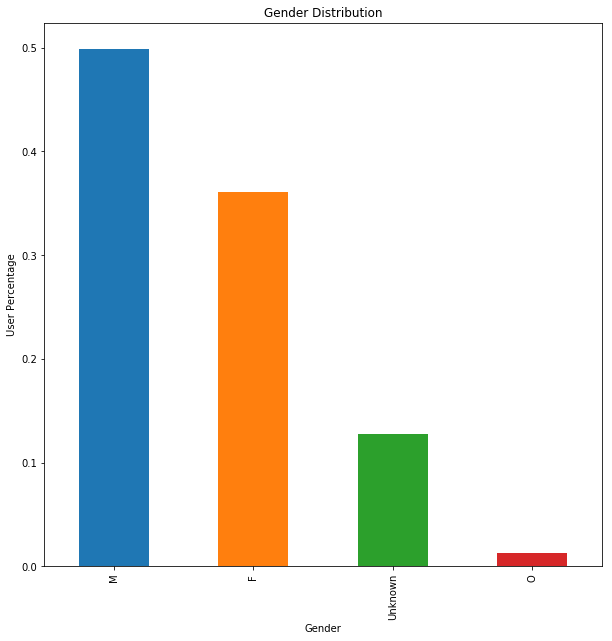

In [14]:
#Take a look at the gender distribution 
profile.gender.value_counts(normalize=True).plot('bar', figsize = (10,10))
plt.title('Gender Distribution')
plt.ylabel('User Percentage', fontsize = 10)
plt.xlabel('Gender', fontsize = 10);

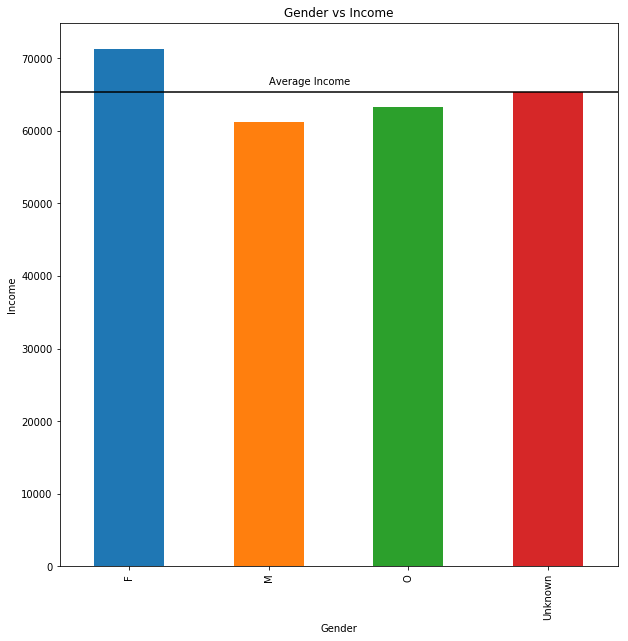

In [15]:
#Income vs Gender Plot
gender_income = profile.groupby('gender', as_index=False).agg({'income':'mean'})
gender_income.plot(kind = 'bar', x = 'gender', y = 'income', legend=False, figsize=(10,10))
plt.hlines(mean_val, -100 , 1000)
plt.ylabel('Income', fontsize = 10)
plt.xlabel('Gender', fontsize = 10)
plt.title('Gender vs Income')
plt.text(1, mean_val + 1000, 'Average Income');

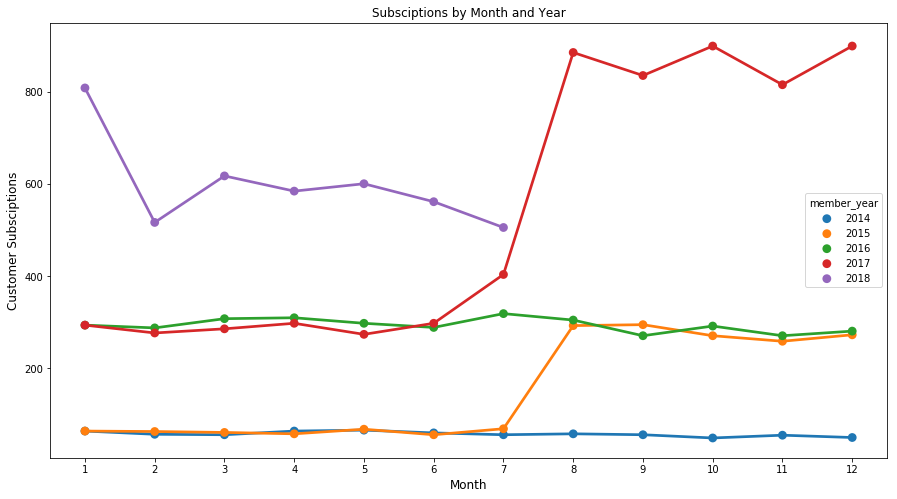

In [16]:
membership_subs = profile[profile['member_year'] >= 2014].groupby(['member_year','member_month'], as_index=False).agg({'id':'count'})
plt.figure(figsize=(15,8))
sns.pointplot(x="member_month", y="id", hue="member_year", data = membership_subs)
plt.ylabel('Customer Subsciptions', fontsize = 12)
plt.xlabel('Month', fontsize = 12)
plt.title('Subsciptions by Month and Year');

In [17]:
#Pecentage of bogo or discount 
trans_and_offers = pd.merge(transcript[(transcript['value_type'] == 'offer_id') & (transcript['event'] == 'offer completed')]
                            , portfolio, how = 'inner', left_on = 'value', right_on = 'id')
trans_and_offers['offer_type'].value_counts(normalize = True)

discount    0.533369
bogo        0.466631
Name: offer_type, dtype: float64

In [18]:
test_person_transactions = transcript[(transcript['person'] == '8dbfa485249f409aa223a2130f40634a')
          & (transcript['value_type'] == 'amount')].reset_index()
# Create days since last purchase column
test_person_transactions['DaysFromLastPurchase'] = test_person_transactions.time.diff()


test_person_transactions.iloc[0, -1] = test_person_transactions.loc[0, 'time']

#Make sure its float
test_person_transactions['value'] = test_person_transactions['value'].apply(lambda x: float(x))

test_person_transactions.drop('index', axis = 1, inplace = True)
test_person_transactions.head(10)

,event,person,time,value,value_type,DaysFromLastPurchase
0,transaction,8dbfa485249f409aa223a2130f40634a,6,3.86,amount,6.0
1,transaction,8dbfa485249f409aa223a2130f40634a,30,0.88,amount,24.0
2,transaction,8dbfa485249f409aa223a2130f40634a,36,2.86,amount,6.0
3,transaction,8dbfa485249f409aa223a2130f40634a,54,0.17,amount,18.0
4,transaction,8dbfa485249f409aa223a2130f40634a,78,1.02,amount,24.0
5,transaction,8dbfa485249f409aa223a2130f40634a,84,0.49,amount,6.0
6,transaction,8dbfa485249f409aa223a2130f40634a,108,1.72,amount,24.0
7,transaction,8dbfa485249f409aa223a2130f40634a,186,1.66,amount,78.0
8,transaction,8dbfa485249f409aa223a2130f40634a,192,0.61,amount,6.0
9,transaction,8dbfa485249f409aa223a2130f40634a,228,1.31,amount,36.0


In [19]:
# average transaction amount, average days between purchases, customers since
test_person_transactions.groupby('person').agg({
                                                'value':'mean' 
                                               , 'DaysFromLastPurchase':'mean' 
                                                , 'time':'mean' 
                                               })

,value,DaysFromLastPurchase,time
person,,,
8dbfa485249f409aa223a2130f40634a,2.123889,18.833333,379


In [20]:
test_completion = pd.merge(
                    transcript[transcript['event'] == 'offer received']
                    , transcript[transcript['event'] == 'offer completed']
                    , how = 'left'
                    , left_on = ['person','value']
                    , right_on = ['person','value']
        )

# Make sure that the time values are converted to floats
test_completion['time_y'] = test_completion['time_y'].apply(lambda x: float(x))
test_completion['time_x'] = test_completion['time_x'].apply(lambda x: float(x))

In [21]:
test_completion.head()

,event_x,person,time_x,value,value_type_x,event_y,time_y,value_type_y
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer id,offer completed,132.0,offer_id
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer id,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,offer id,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,fafdcd668e3743c1bb461111dcafc2a4,offer id,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,offer id,NaN,NaN,NaN


In [22]:
completion = test_completion[
    (
        (test_completion['time_y'] <= (test_completion['time_x'] + 20)) 
        & (test_completion['time_y'] >= test_completion['time_x'])  
    )
    
    | 
    
    (pd.isnull(test_completion['event_y']) == True) 
        ][['person','time_x','value','event_y','time_y']]

completion['DaysToCompleteOffer'] = completion['time_y'] - completion['time_x'] 
completion['CompletedOffer'] = completion['event_y'].apply(lambda x: 0 if pd.isnull(x) == True else 1)
completion.tail()

,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
86425,f924927e7f844ecebf87eef93f4d2688,576.0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,0
86426,a57890c3bbb7463e9018abb7fecadb15,576.0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,0
86429,6d5f3a774f3d4714ab0c092238f3a1d7,576.0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,0
86430,9dc1421481194dcd9400aec7c9ae6366,576.0,ae264e3637204a6fb9bb56bc8210ddfd,offer completed,594.0,18.0,1
86431,e4052622e5ba45a8b96b59aba68cf068,576.0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,0


In [23]:
completion[completion['person'] == '8dbfa485249f409aa223a2130f40634a']


,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
5765,8dbfa485249f409aa223a2130f40634a,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,0
63399,8dbfa485249f409aa223a2130f40634a,504.0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN,0


In [24]:
completion[completion['person'] == '9dc1421481194dcd9400aec7c9ae6366']


,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
57550,9dc1421481194dcd9400aec7c9ae6366,408.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completed,414.0,6.0,1
86430,9dc1421481194dcd9400aec7c9ae6366,576.0,ae264e3637204a6fb9bb56bc8210ddfd,offer completed,594.0,18.0,1


In [25]:
completion[completion['person'] == '9dc1421481194dcd9400aec7c9ae6366'].groupby('person').agg({
    
    'time_x':'min' 
    , 'CompletedOffer': 'mean' 
    , 'DaysToCompleteOffer': 'mean' 
})

,time_x,CompletedOffer,DaysToCompleteOffer
person,,,
9dc1421481194dcd9400aec7c9ae6366,408.0,1,12.0


In [26]:
offers_df = pd.merge(completion
         ,portfolio
         , how = 'inner'
         , left_on = 'value'
         , right_on = 'id'
        )[['person','time_x','value','CompletedOffer','DaysToCompleteOffer'
          , 'difficulty','duration','offer_type','reward','email','mobile','social','web'
          ]]
offers_df.columns = ['person','offer_time','value','CompletedOffer','DaysToCompleteOffer'
                          ,'difficulty','duration','offer_type','reward'
                          , 'email','mobile','social','web'
                        ]
offers_df['NetReward'] = offers_df['reward'] - offers_df['difficulty']
offers_df.tail()

,person,offer_time,value,CompletedOffer,DaysToCompleteOffer,difficulty,duration,offer_type,reward,email,mobile,social,web,NetReward
48845,db1805ed333844978e8b46ed3e4643ae,576.0,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,5,5,bogo,5,1,1,1,1,0
48846,eec70ab28af74a22a4aeb889c0317944,576.0,f19421c1d4aa40978ebb69ca19b0e20d,1,18.0,5,5,bogo,5,1,1,1,1,0
48847,31e915c24163436790b97c1d45b545f6,576.0,f19421c1d4aa40978ebb69ca19b0e20d,1,18.0,5,5,bogo,5,1,1,1,1,0
48848,361539b15a6243dc834c6b25e481570b,576.0,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,5,5,bogo,5,1,1,1,1,0
48849,eb7dd979f4644052a5c401a01f129132,576.0,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,5,5,bogo,5,1,1,1,1,0


In [27]:
final_offers_df = offers_df.groupby(['offer_type','difficulty','reward'], as_index = False).agg({
    'CompletedOffer':['mean', 'sum'] 
    , 'DaysToCompleteOffer':'mean' 
    , 'NetReward': 'max' 
})

final_offers_df.columns.droplevel(1)
final_offers_df.columns = ['offer_type','difficulty','reward','CompletedOffers','TotalCompletions'
                            , 'AvgDaysToComplete','NetReward']
final_offers_df['NetWorth'] = (final_offers_df['CompletedOffers'] * final_offers_df['NetReward']) * -1
final_overall_offers_df = final_offers_df[final_offers_df['offer_type'] != 'informational']
final_overall_offers_df

,offer_type,difficulty,reward,CompletedOffers,TotalCompletions,AvgDaysToComplete,NetReward,NetWorth
0,bogo,5,5,0.308293,2606,8.638526,0,-0.000000
1,bogo,10,10,0.217532,2149,9.001396,0,-0.000000
2,discount,7,3,0.383878,1362,8.938326,-4,1.535513
3,discount,10,2,0.279512,2060,8.906796,-8,2.236092
4,discount,20,5,0.090034,393,9.511450,-15,1.350515


In [28]:
all_transactions = transcript[transcript['value_type'] == 'amount']
all_transactions['value'] = all_transactions['value'].apply(lambda x: float(x))
all_transactions.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,event,person,time,value,value_type
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,amount
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,amount
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,amount
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,amount
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,amount


In [29]:
df_all_customers = pd.DataFrame(columns = ['person', 'discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers' 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
       'income', 'member_date', 'total_transactions', 'min_transaction_day',
       'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
       'median_days_between_purchases', 'avg_days_between_purchases'])

for person in np.unique(profile['id']):
    
    
    personal_profile = profile[profile['id'] == person][['id','age','gender','income','member_date']]
    
    
    personal_transactions = all_transactions[all_transactions['person'] == person].reset_index()
    if len(personal_transactions) > 0:
        personal_transactions['DaysFromLastPurchase'] = personal_transactions.time.diff()
        personal_transactions.iloc[0, -1] = test_person_transactions.loc[0, 'time']

        personal_agg_trans = personal_transactions.groupby('person', as_index = False).agg(
        {
            'time': ['count','min','max'] 
            , 'value': ['mean', 'sum'] 
            , 'DaysFromLastPurchase': ['median', 'mean']   
        })
        personal_agg_trans.columns = personal_agg_trans.columns.droplevel(1) 
        personal_agg_trans.columns = ['person', 'total_transactions','min_transaction_day','max_transaction_day'
                                      , 'avg_transaction','total_transaction_amount','median_days_between_purchases'
                                      ,'avg_days_between_purchases']
    else:
        null_array = [person, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
        personal_agg_trans = pd.DataFrame([null_array]
                                         , columns = ['person', 'total_transactions','min_transaction_day'
                                                      ,'max_transaction_day'
                                                      , 'avg_transaction','median_days_between_purchases'
                                                      ,'avg_days_between_purchases'])
        
        
    
    personal_df_1 = pd.merge(personal_profile, personal_agg_trans
                             , how = 'inner', left_on = 'id', right_on = 'person')
    personal_df_1.drop('id', axis = 1, inplace = True) 
    
    
    
    for offer_type in ['discount','bogo']:
        globals()[offer_type + '_df'] =  offers_df[(offers_df['person'] == person)
                       & (offers_df['offer_type'] == offer_type)
                       ].groupby('person', as_index = False).agg({
                                                        'CompletedOffer':['count','mean','sum']
                                                        , 'DaysToCompleteOffer': ['min','max','mean']
                                                        , 'NetReward': ['mean']
                                                    })
        
        globals()[offer_type + '_df'].columns = globals()[offer_type + '_df'].columns.droplevel(1)
        globals()[offer_type + '_df'].columns = ['person', offer_type + '_total_offers'
                                    ,offer_type + '_completion_pct', offer_type + '_completed_offers'
                                   , offer_type + '_min_completion_days',offer_type + '_max_completion_days'
                                    ,offer_type + '_avg_completion_days', offer_type + '_avg_net_reward']
        
        if len(globals()[offer_type + '_df']) == 0:
            null_array = [person,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan, np.nan]
            globals()[offer_type + '_df'] = globals()[offer_type + '_df'].append(
                dict(zip(globals()[offer_type + '_df'].columns, null_array)), ignore_index=True
            )
    
    
    bogo_and_discounts = pd.merge(discount_df, bogo_df)
    bogo_and_discounts['informational_promotions'] = len(offers_df[(offers_df['person'] == person)
                                                               & (offers_df['offer_type'] == 'informational')])
    
    
    person_final = pd.merge(bogo_and_discounts, personal_df_1)
    
    
    df_all_customers = df_all_customers.append(person_final)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [30]:
df_all_customers = df_all_customers[['person', 'discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers' 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
       'income', 'member_date', 'total_transactions', 'min_transaction_day',
       'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
       'median_days_between_purchases', 'avg_days_between_purchases']]

In [31]:
df_all_customers.head(10)

,person,discount_total_offers,discount_completion_pct,discount_min_completion_days,discount_max_completion_days,discount_completed_offers,discount_avg_completion_days,discount_avg_net_reward,bogo_total_offers,bogo_completion_pct,...,gender,income,member_date,total_transactions,min_transaction_day,max_transaction_day,avg_transaction,total_transaction_amount,median_days_between_purchases,avg_days_between_purchases
0,0009655768c64bdeb2e877511632db8f,1,1,0.0,0.0,1,0.0,-8,1,1,...,M,72000.000000,2017-04-21,8,228,696,15.950000,127.60,27.0,59.250000
0,00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,...,Unknown,65404.991568,2018-04-25,3,294,474,1.363333,4.09,18.0,62.000000
0,0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,O,57000.000000,2018-01-09,5,132,654,15.892000,79.46,66.0,105.600000
0,0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,...,F,90000.000000,2016-03-04,8,54,708,24.607500,196.86,21.0,82.500000
0,0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,F,60000.000000,2016-11-11,12,42,672,12.837500,154.05,30.0,53.000000
0,003d66b6608740288d6cc97a6903f4f0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,F,73000.000000,2017-06-21,18,66,696,2.685556,48.34,21.0,35.333333
0,00426fe3ffde4c6b9cb9ad6d077a13ea,3,0,NaN,NaN,0,NaN,-10.3333,NaN,NaN,...,F,65000.000000,2016-08-09,17,36,696,4.030000,68.51,18.0,39.176471
0,004b041fbfe44859945daa2c7f79ee64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,F,74000.000000,2018-05-08,6,18,714,23.060000,138.36,90.0,117.000000
0,004c5799adbf42868b9cff0396190900,1,1,0.0,0.0,1,0.0,-8,1,1,...,M,99000.000000,2016-03-31,12,222,690,28.948333,347.38,27.0,39.500000
0,005500a7188546ff8a767329a2f7c76a,1,0,NaN,NaN,0,NaN,-8,3,0,...,M,47000.000000,2017-12-09,4,204,588,5.090000,20.36,33.0,97.500000


# Clustering 

In [32]:
from sklearn import cluster
from sklearn.cluster import KMeans

In [33]:
cluster_df = df_all_customers[['discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers' 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
       'income', 'total_transactions', 'min_transaction_day',
       'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
       'median_days_between_purchases', 'avg_days_between_purchases']].fillna(0)


cluster_df_new = pd.get_dummies(data=cluster_df, columns=['gender'])

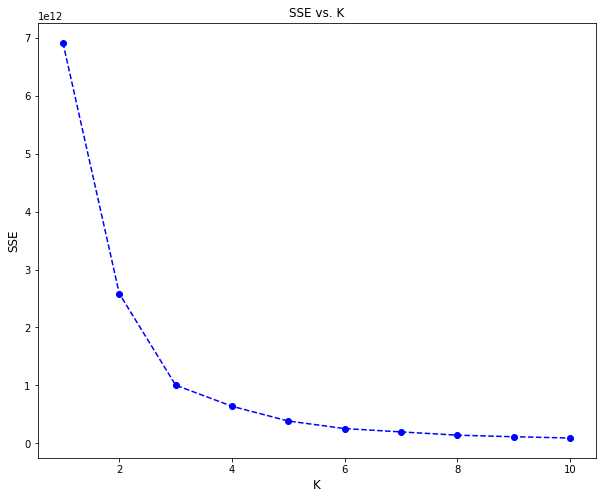

In [35]:
scores = []

for k in range(1,11):
    kmeans = KMeans(k)
    
    model = kmeans.fit(cluster_df_new)
    
    scores.append(abs(model.score(cluster_df_new)))
    
plt.figure(figsize=(10,8))
plt.plot(range(1,11), scores, linestyle='--', marker='o', color='b');
plt.xlabel('K', fontsize = 12);
plt.ylabel('SSE', fontsize = 12);
plt.title('SSE vs. K', fontsize = 12);

In [36]:
# Creating 3 clusters 
clust = cluster.AgglomerativeClustering(3, linkage='ward')

optimal_cluster = df_all_customers[['discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers' 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
       'income', 'total_transactions', 'min_transaction_day',
       'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
       'median_days_between_purchases', 'avg_days_between_purchases']].fillna(0)

optimal_cluster_new = pd.get_dummies(data=optimal_cluster, columns=['gender'])

df_all_customers['Clusters'] = clust.fit_predict(optimal_cluster_new)

In [37]:
df_all_customers.head()

,person,discount_total_offers,discount_completion_pct,discount_min_completion_days,discount_max_completion_days,discount_completed_offers,discount_avg_completion_days,discount_avg_net_reward,bogo_total_offers,bogo_completion_pct,...,income,member_date,total_transactions,min_transaction_day,max_transaction_day,avg_transaction,total_transaction_amount,median_days_between_purchases,avg_days_between_purchases,Clusters
0,0009655768c64bdeb2e877511632db8f,1,1,0.0,0.0,1,0.0,-8,1,1,...,72000.000000,2017-04-21,8,228,696,15.950000,127.60,27.0,59.25,2
0,00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,...,65404.991568,2018-04-25,3,294,474,1.363333,4.09,18.0,62.00,2
0,0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57000.000000,2018-01-09,5,132,654,15.892000,79.46,66.0,105.60,0
0,0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,...,90000.000000,2016-03-04,8,54,708,24.607500,196.86,21.0,82.50,1
0,0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60000.000000,2016-11-11,12,42,672,12.837500,154.05,30.0,53.00,0


In [38]:
df_all_customers.Clusters.value_counts(normalize = True)

0    0.408882
2    0.334941
1    0.256176
Name: Clusters, dtype: float64

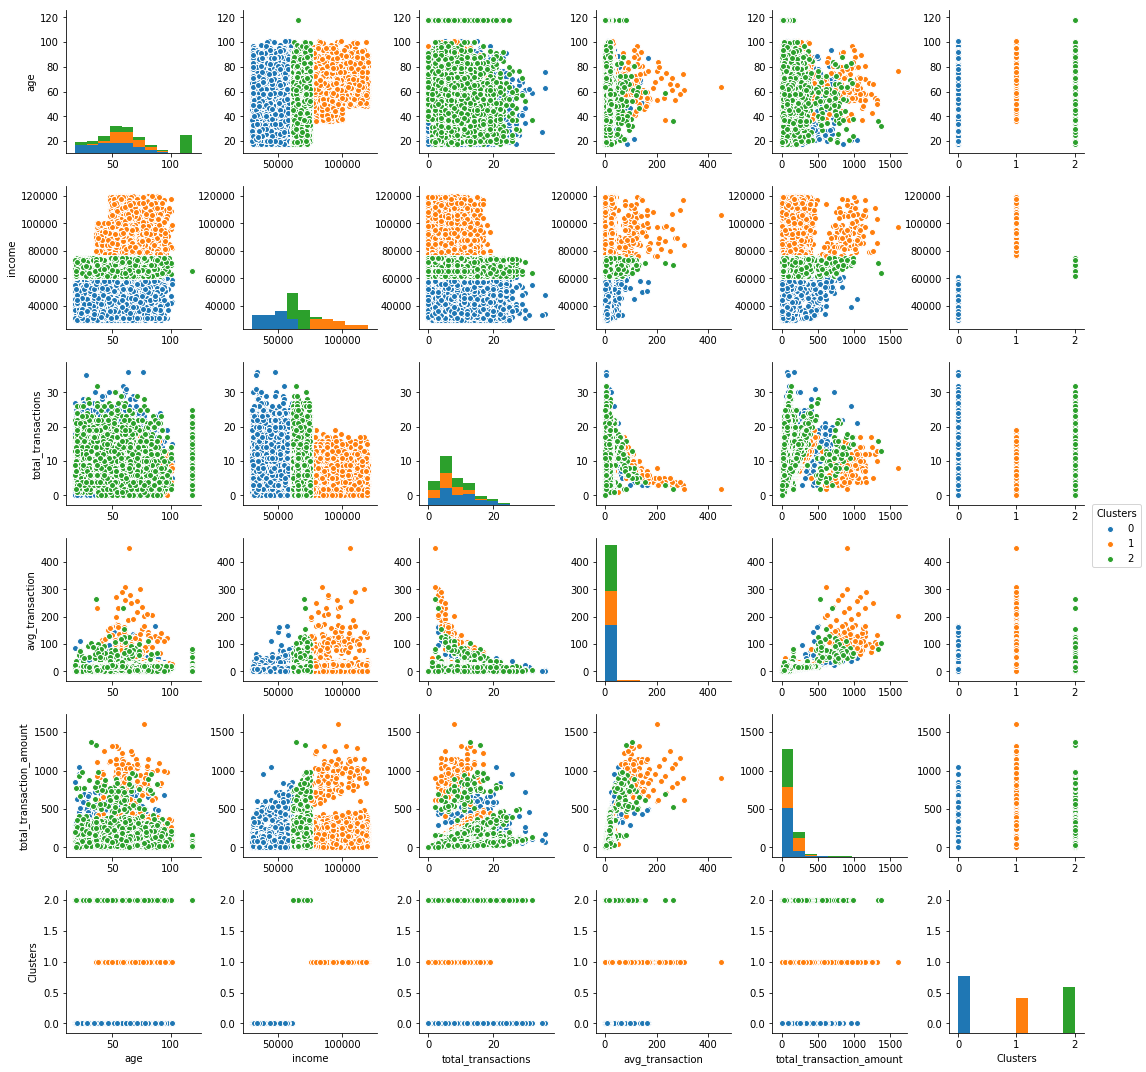

In [39]:
visual_columns = ['age'
                  , 'gender'
                  ,'income'
                  , 'total_transactions'
                  , 'avg_transaction'
                  , 'total_transaction_amount'
                  ,'Clusters']

sns_personal_attributes = sns.pairplot(df_all_customers[visual_columns].fillna(0), hue='Clusters');
sns_personal_attributes.savefig("personal_attributes_clusters.png")

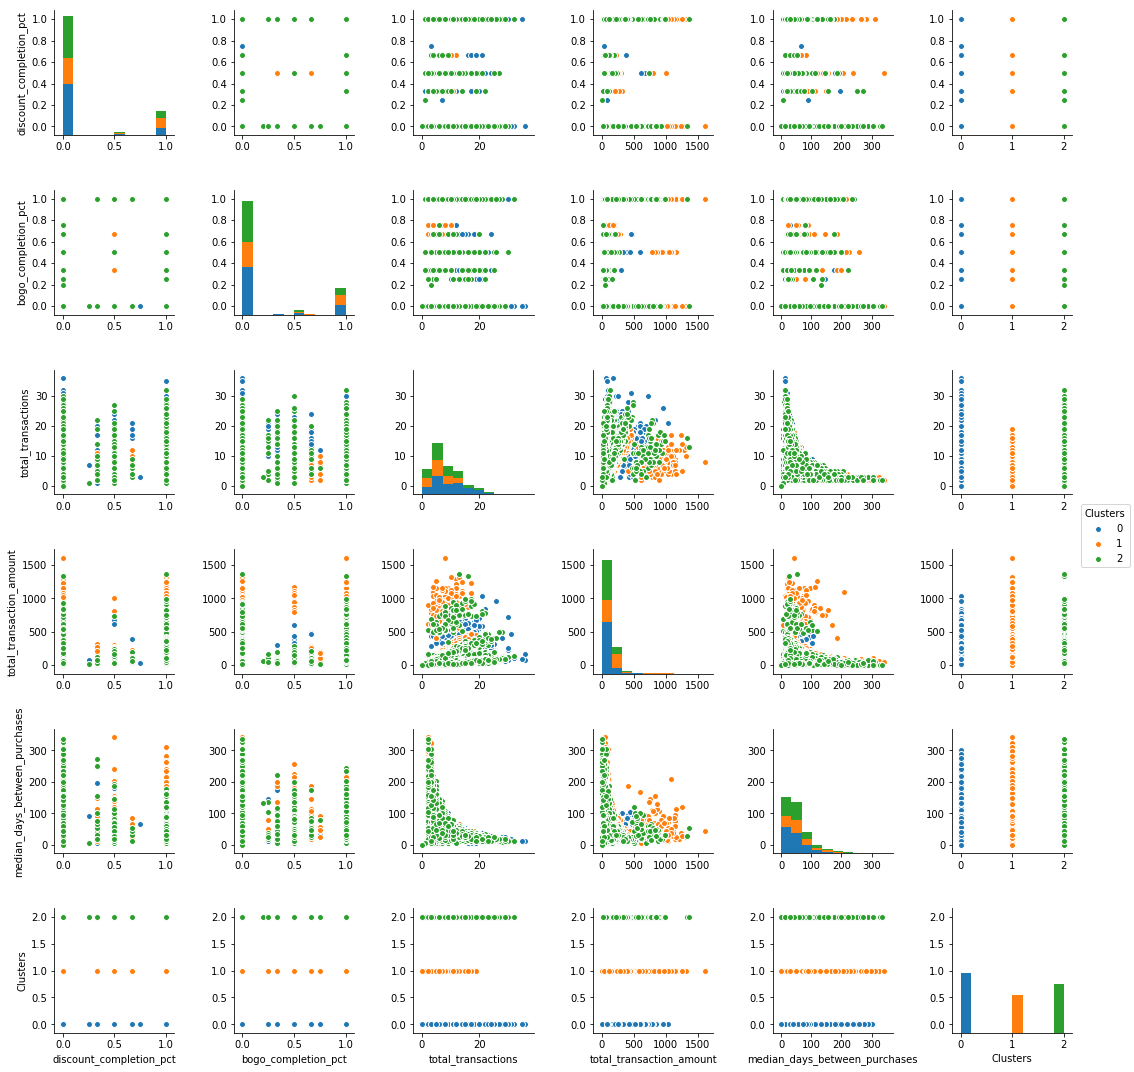

In [40]:
visual_columns = ['discount_completion_pct','bogo_completion_pct',
        'total_transactions', 'total_transaction_amount',
       'median_days_between_purchases','Clusters']

seaborn_trans_info = sns.pairplot(df_all_customers[visual_columns].fillna(0), hue='Clusters')
seaborn_trans_info.savefig("personal_transactions_clusters.png")

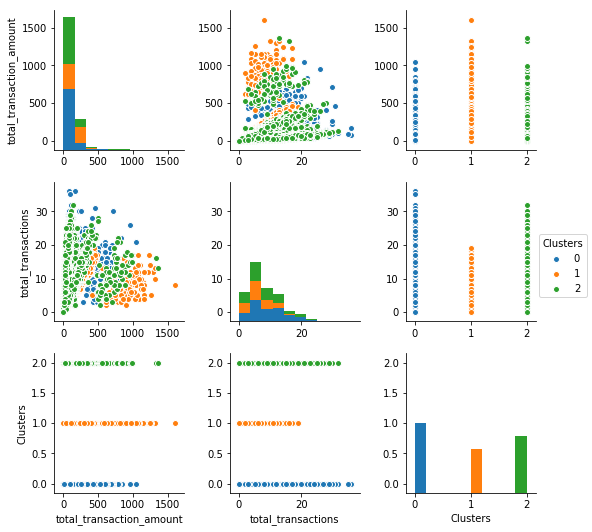

In [41]:
plt.figure(figsize= (10,8))
sns.pairplot(df_all_customers[['total_transaction_amount','total_transactions','Clusters']].fillna(0), hue='Clusters');


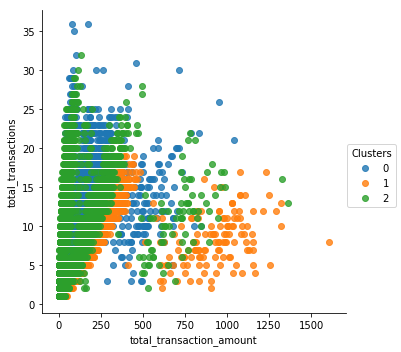

In [42]:
plt.figure(figsize = (20,10))
sns.lmplot(x='total_transaction_amount', y='total_transactions', hue='Clusters'
           , data=df_all_customers, fit_reg=False);

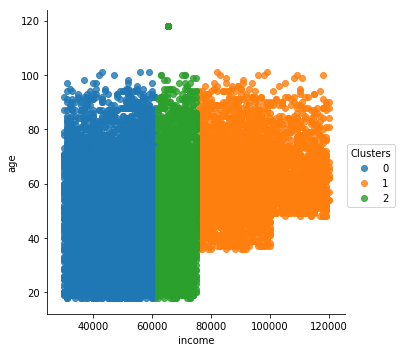

In [50]:
plt.figure(figsize = (20,20));
sns.lmplot(x='income', y='age', hue='Clusters'
           , data=df_all_customers, fit_reg=False);

In [44]:
clust_offer = pd.merge(offers_df, df_all_customers[['person','Clusters']]).groupby(
                            ['Clusters','offer_type','difficulty','reward']
                            , as_index = False ).agg({

     'CompletedOffer':['mean', 'sum'] 
    , 'DaysToCompleteOffer':'mean' 
    , 'NetReward': 'max' 
})

clust_offer = clust_offer[clust_offer['offer_type'] != 'informational']
clust_offer.columns.droplevel(1)
clust_offer.columns = ['Clusters','offer_type','difficulty','reward' , 'CompletedOffers','TotalCompletions','AvgDaysToCompleteOffer','NetReward']

In [45]:
clust_offer

,Clusters,offer_type,difficulty,reward,CompletedOffers,TotalCompletions,AvgDaysToCompleteOffer,NetReward
0,0,bogo,5,5,0.287234,1026,8.801170,0
1,0,bogo,10,10,0.156899,688,9.034884,0
2,0,discount,7,3,0.367496,502,8.677291,-4
3,0,discount,10,2,0.215789,656,8.917683,-8
4,0,discount,20,5,0.037056,73,12.246575,-15
6,1,bogo,5,5,0.511532,865,8.608092,0
7,1,bogo,10,10,0.526596,891,9.077441,0
8,1,discount,7,3,0.602015,478,8.924686,-4
9,1,discount,10,2,0.561009,823,8.712029,-8
10,1,discount,20,5,0.340974,238,8.394958,-15


In [46]:
def bogo_or_discount(row):
    offer_type = row['offer_type']
    cluster_val = row['ClusterCompletedOffers']
    avg_val = row['AvgCompletedOffers']
    
    if cluster_val > avg_val:
        return 'discount'
    else:
        return 'bogo'

In [47]:
rewards_comparisons = pd.merge(clust_offer
         , final_overall_offers_df[['offer_type','difficulty','reward', 'CompletedOffers']]
         , how = 'inner'
         , on = ['offer_type','difficulty','reward']
        ).sort_values(['Clusters','offer_type','difficulty','reward'])
rewards_comparisons.columns = ['Clusters', 'offer_type', 'difficulty', 'reward', 'ClusterCompletedOffers',
       'TotalCompletions', 'AvgDaysToCompleteOffer', 'NetReward',
       'AvgCompletedOffers']

rewards_comparisons['BOGO_or_Discount'] = rewards_comparisons.apply(bogo_or_discount, axis = 1)
rewards_comparisons[['Clusters', 'offer_type', 'difficulty', 'reward'
                  , 'ClusterCompletedOffers','AvgCompletedOffers','BOGO_or_Discount']
                 ].set_index(['Clusters','offer_type'
                            ,'difficulty', 'reward'])

ClusterCompletedOffers  \
Clusters offer_type difficulty reward                           
0        bogo       5          5                     0.287234   
                    10         10                    0.156899   
         discount   7          3                     0.367496   
                    10         2                     0.215789   
                    20         5                     0.037056   
1        bogo       5          5                     0.511532   
                    10         10                    0.526596   
         discount   7          3                     0.602015   
                    10         2                     0.561009   
                    20         5                     0.340974   
2        bogo       5          5                     0.224138   
                    10         10                    0.149921   
         discount   7          3                     0.275216   
                    10         2                     0.202934   
                    20         5                     0.048321   

                                       AvgCompletedOffers BOGO_or_Discount  
Clusters offer_type difficulty reward                                       
0        bogo       5          5                 0.308293             bogo  
                    10         10                0.217532             bogo  
         discount   7          3                 0.383878             bogo  
                    10         2                 0.279512             bogo  
                    20         5                 0.090034             bogo  
1        bogo       5          5                 0.308293         discount  
                    10         10                0.217532         discount  
         discount   7          3                 0.383878         discount  
                    10         2                 0.279512         discount  
                    20         5                 0.090034         discount  
2        bogo       5          5                 0.308293             bogo  
                    10         10                0.217532             bogo  
         discount   7          3                 0.383878             bogo  
                    10         2                 0.279512             bogo  
                    20         5                 0.090034             bogo

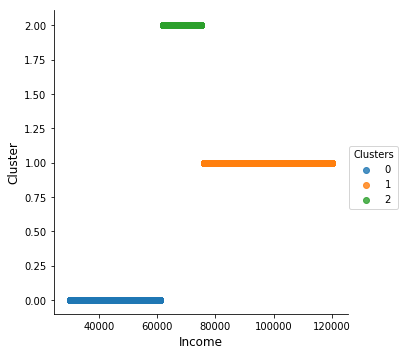

In [48]:
sns.lmplot(x='income', y='Clusters', hue='Clusters', data=df_all_customers, fit_reg=False)
plt.xlabel('Income', fontsize = 12)
plt.ylabel('Cluster', fontsize = 12)
plt.figure(figsize=(10,10))

# Conclusion
Clustering by income works well to differentiate between the app users. From what we can see in the final chart, the higher income indivduals overall respond better with the discount offers, and the lower income individuals respond better to BOGO rewards. However there are some problems with the method, for example many of the users in the dataset did not have an income associated with their account. To combat this I filled the empty values with the mean income, for this experiment that solution works. However if a new user signs up for the app and does not provide any income there would be no way to tell which reward to send them. Instead I believe we could use something like a ranked based recommendation to solve this issue. Send them one of the rewards that are more popular among all of the clusters, then as the user complete more offers we can begin to group them into a certain cluster.